# Modelling, Evaluation and Augmentation

## Objectives

## Inputs

## Outputs

---

---

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set directory

Set the train, validation and test path directories

In [2]:
cwd= os.getcwd()
os.chdir('/workspaces/cherry-leaves-project')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspaces/cherry-leaves-project'

### Input directory

In [3]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/val'
test_path = data_dir + '/test'

### Output directory

In [4]:
ver = 'v1'
file_path = f'outputs/{ver}'

if 'outputs' in os.listdir(work_dir) and ver in os.listdir(work_dir + '/outputs'):
  print('Old version is available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is available create a new version.


### Labels

In [5]:
labels = os.listdir(train_path)
print('Title for the images are',labels)

Title for the images are ['healthy', 'powdery_mildew']


### Image Shape

In [6]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Total Images In Each Set

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* val - healthy: 210 images
* val - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




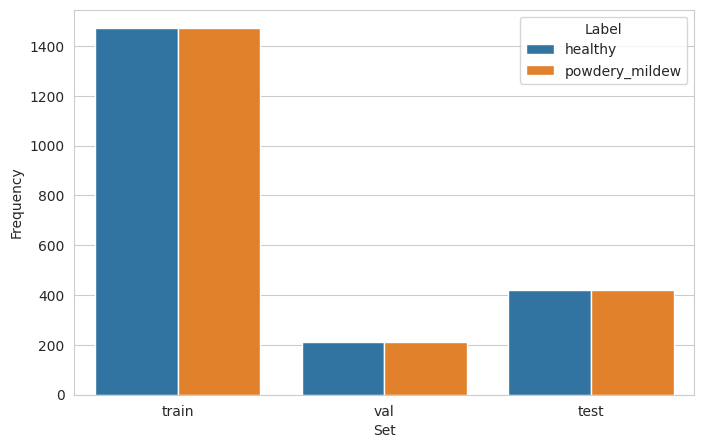

In [21]:
img_data_freq = pd.DataFrame([]) 
for folder in ['train', 'val', 'test']:
  for label in labels:
    img_data_freq = img_data_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=img_data_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Augmentation

---

### Image Data Generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Initialize

In [9]:
augmented_image = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

#### Augment Train Dataset

In [10]:
batch_size = 20 # Set batch size
train_set = augmented_image.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment Test Dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment Validation Dataset

In [15]:
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

val_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plots

### Plot Augmented Images


#### Train Set


(20, 256, 256, 3)


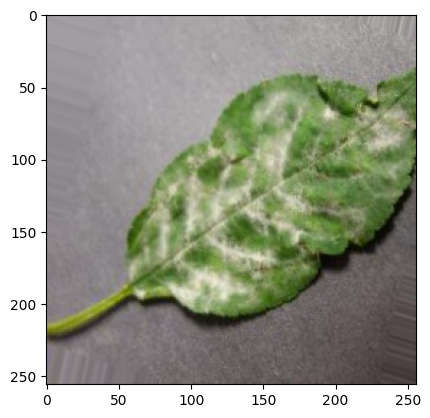

(20, 256, 256, 3)


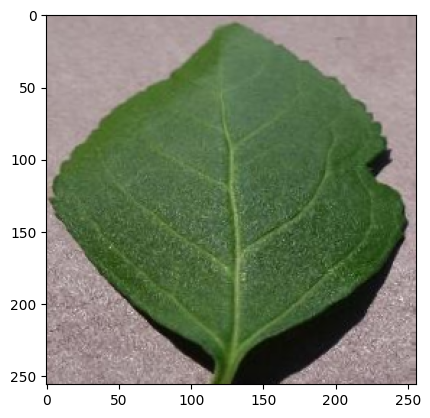

(20, 256, 256, 3)


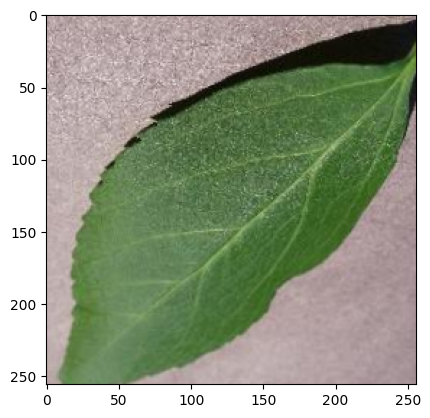

In [12]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Validation set

(20, 256, 256, 3)


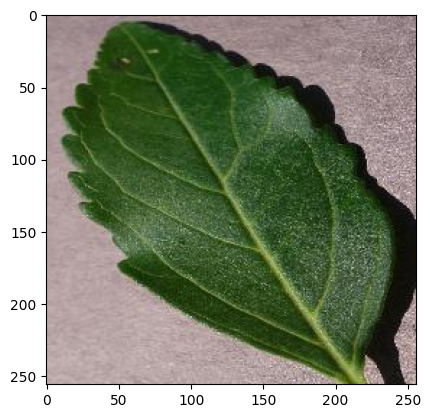

(20, 256, 256, 3)


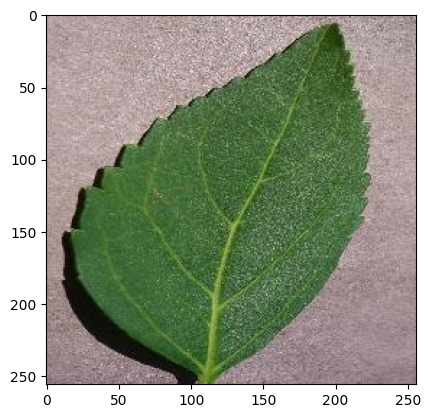

(20, 256, 256, 3)


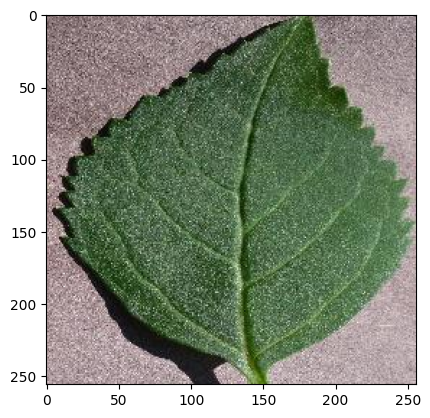

In [16]:
for _ in range(3):
    img, label = val_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save Plots

In [17]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Create the Model

---

### Machine Learning Model

#### Import Packages

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### The Model (CNN) and Model Summary

In [23]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [25]:
create_model().summary()

2024-01-04 20:47:03.307446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
model = create_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/10
147/147 [==============================] - 723s 5s/step - loss: 0.4017 - accuracy: 0.8102 - val_loss: 0.1881 - val_accuracy: 0.9357
Epoch 2/10
147/147 [==============================] - 761s 5s/step - loss: 0.0919 - accuracy: 0.9750 - val_loss: 0.0330 - val_accuracy: 0.9929
Epoch 3/10
147/147 [==============================] - 691s 5s/step - loss: 0.0408 - accuracy: 0.9880 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 4/10
147/147 [==============================] - 679s 5s/step - loss: 0.0330 - accuracy: 0.9911 - val_loss: 0.0929 - val_accuracy: 0.9881
Epoch 5/10
147/147 [==============================] - 553s 4s/step - loss: 0.0420 - accuracy: 0.9891 - val_loss: 0.0034 - val_accuracy: 0.9976
Epoch 6/10
147/147 [==============================] - 372s 3s/step - loss: 0.0595 - accuracy: 0.9826 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 7/10
147/147 [==============================] - 529s 4s/step - loss: 0.0233 - accuracy: 0.9949 - val_loss: 0.0509 - val_accuracy: 0.9857

In [33]:
model.save('outputs/v1/mildew_detector_model.h5')

---

## Performance

---

### Model Learning Curve

In [34]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/training_model_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/training_model_acc.png', bbox_inches='tight', dpi=150)
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

### Model Evaluation

Saved model

In [ ]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

Evaluate on test set

In [ ]:
evaluation = model.evaluate(test_set)

### Save Evaluation

In [ ]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

## Prediction

Load a new image

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # healthy or powdery mildew

pred_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pred_image.size}, Image mode: {pred_image.mode}')
pred_image

Preparation and conversion

In [ ]:
image_curr = image.img_to_array(pred_image)
image_curr = np.expand_dims(image_curr, axis=0)
print(image_curr.shape)

Predict class

In [ ]:
pred_proba = model.predict(image_curr)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)